In [1]:
from google.colab import drive

# Google 드라이브 마운트
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
import os

# Paths to your data directories
train_dir = '/content/drive/MyDrive/ddubuk_cls/ddubuk/train'
test_dir = '/content/drive/MyDrive/ddubuk_cls/ddubuk/test'

# Count images in each subfolder
turtle_images = len(os.listdir(os.path.join(train_dir, 'ddubuk')))
not_turtle_images = len(os.listdir(os.path.join(train_dir, 'not_ddubuk')))

print(f"Number of 'turtle' images: {turtle_images}")
print(f"Number of 'not turtle' images: {not_turtle_images}")

Number of 'turtle' images: 83
Number of 'not turtle' images: 15


In [3]:
!pip install pillow_heif

In [4]:
import os
import shutil
import random
from PIL import Image
import pillow_heif # Import the pillow_heif library
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Convert HEIC files to JPEG
def convert_heic_to_jpg(input_dir, output_dir):
    if not os.path.exists(output_dir):
        os.makedirs(output_dir)

    for sub_dir in ['ddubuk', 'not_ddubuk']:
        input_sub_dir = os.path.join(input_dir, sub_dir)
        output_sub_dir = os.path.join(output_dir, sub_dir)

        if not os.path.exists(output_sub_dir):
            os.makedirs(output_sub_dir)

        for file_name in os.listdir(input_sub_dir):
            if file_name.lower().endswith('.heic'):
                heic_path = os.path.join(input_sub_dir, file_name)
                jpg_file_name = file_name.replace('.HEIC', '.jpg')
                jpg_path = os.path.join(output_sub_dir, jpg_file_name)

                # Open and convert the HEIC file using pillow_heif
                heif_file = pillow_heif.read_heif(heic_path)
                image = Image.frombytes(
                    heif_file.mode,
                    heif_file.size,
                    heif_file.data,
                    "raw"
                )
                image.save(jpg_path, 'JPEG')
            else:
                # Copy other formats directly to output directory
                shutil.copy(os.path.join(input_sub_dir, file_name), output_sub_dir)


In [5]:
# Define directories
input_dir = '/content/drive/MyDrive/ddubuk_cls/ddubuk/test'  # Original images
output_dir = '/content/drive/MyDrive/ddubuk_cls/ddubuk/test_converted'  # Converted images

# Convert HEIC images to JPG and prepare the output directory
convert_heic_to_jpg(input_dir, output_dir)

In [6]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Dense, Flatten, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.applications import Xception
from tensorflow.keras.layers import GlobalAveragePooling2D
from sklearn.utils.class_weight import compute_class_weight
import numpy as np
import os

# Paths to the directories
train_dir = '/content/drive/MyDrive/ddubuk_cls/ddubuk/train_converted'
test_dir = '/content/drive/MyDrive/ddubuk_cls/ddubuk/test_converted'

# Data augmentation for training data
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest',
    validation_split=0.2  # 20% validation split
)

# Only rescale the test data
test_datagen = ImageDataGenerator(rescale=1./255)

# Load and augment the training data
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(224, 224),
    batch_size=16,
    class_mode='binary',
    subset='training'  # Training data subset
)

# Load and preprocess the validation data
validation_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(224, 224),
    batch_size=16,
    class_mode='binary',
    subset='validation'  # Validation data subset
)

# Load the test data
test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(224, 224),
    batch_size=16,
    class_mode='binary',
    shuffle=False  # Do not shuffle test data
)


Found 63 images belonging to 2 classes.
Found 15 images belonging to 2 classes.
Found 21 images belonging to 2 classes.


In [7]:
# Base model: Xception with pre-trained weights on ImageNet
base_model = Xception(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Freeze the layers of the base model
for layer in base_model.layers:
    layer.trainable = False

# Adding custom layers on top of the base model
x = base_model.output
x = GlobalAveragePooling2D()(x)  # Global Average Pooling instead of Flatten
x = Dense(512, activation='relu')(x)
x = Dropout(0.5)(x)
x = Dense(1, activation='sigmoid')(x)  # Sigmoid for binary classification
# Create the final model
model = Model(inputs=base_model.input, outputs=x)
# Compile the model

model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
              loss='binary_crossentropy',
              metrics=['accuracy'])

In [8]:
# Calculate class weights to handle imbalance
class_weights = compute_class_weight('balanced', classes=np.unique(train_generator.classes), y=train_generator.classes)
class_weights = dict(enumerate(class_weights))

# Set up early stopping to avoid overfitting
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Train the model
history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // train_generator.batch_size,
    validation_data=validation_generator,
    validation_steps=validation_generator.samples // validation_generator.batch_size,
    epochs=50,
    class_weight=class_weights,
    callbacks=[early_stopping]
)

Epoch 1/50


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


3/3 ━━━━━━━━━━━━━━━━━━━━ 29s 6s/step - accuracy: 0.7814 - loss: 0.7780 - val_accuracy: 0.8667 - val_loss: 0.4297
Epoch 2/50
1/3 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step - accuracy: 0.8750 - loss: 0.6073

/usr/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 616ms/step - accuracy: 0.8750 - loss: 0.6073 - val_accuracy: 0.8667 - val_loss: 0.4469
Epoch 3/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 7s 970ms/step - accuracy: 0.8183 - loss: 0.5039 - val_accuracy: 0.8667 - val_loss: 0.4036
Epoch 4/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 641ms/step - accuracy: 0.8125 - loss: 0.7853 - val_accuracy: 0.9333 - val_loss: 0.4148
Epoch 5/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 8s 719ms/step - accuracy: 0.8464 - loss: 0.4425 - val_accuracy: 0.9333 - val_loss: 0.4442
Epoch 6/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 3s 1s/step - accuracy: 0.8000 - loss: 0.8475 - val_accuracy: 1.0000 - val_loss: 0.4244
Epoch 7/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 8s 691ms/step - accuracy: 0.7747 - loss: 0.5404 - val_accuracy: 0.9333 - val_loss: 0.4150
Epoch 8/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 496ms/step - accuracy: 0.8125 - loss: 0.4762 - val_accuracy: 0.8667 - val_loss: 0.4992


In [9]:
# Evaluate the model on the validation set
val_loss, val_accuracy = model.evaluate(validation_generator)
print(f'Validation Loss: {val_loss}')
print(f'Validation Accuracy: {val_accuracy}')

# Evaluate the model on the test set
test_loss, test_accuracy = model.evaluate(test_generator)
print(f'Test Loss: {test_loss}')
print(f'Test Accuracy: {test_accuracy}')

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 0.9333 - loss: 0.4040
Validation Loss: 0.404030442237854
Validation Accuracy: 0.9333333373069763
2/2 ━━━━━━━━━━━━━━━━━━━━ 6s 3s/step - accuracy: 0.7887 - loss: 0.4402
Test Loss: 0.48465874791145325
Test Accuracy: 0.7142857313156128


2/2 ━━━━━━━━━━━━━━━━━━━━ 6s 2s/step


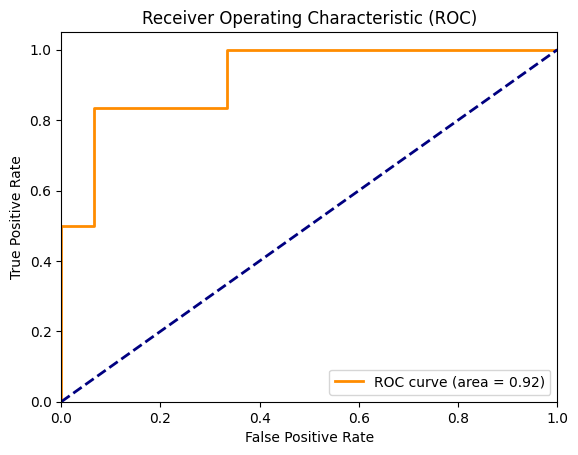

In [10]:
# ROC Curve and AUC Score calculation
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

# Predict probabilities for the test data
y_pred_prob = model.predict(test_generator)

# True labels from the test data
y_true = test_generator.classes

# Calculate the ROC curve
fpr, tpr, thresholds = roc_curve(y_true, y_pred_prob)

# Calculate the AUC score
roc_auc = auc(fpr, tpr)

# Plotting the ROC curve
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc='lower right')
plt.show()